In [10]:
import os
import numpy as np
import tensorflow as tf
import pickle
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [11]:
def load_image(image_path):
    try:
        img = load_img(image_path, target_size=(256, 256))
        img_array = img_to_array(img)
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

In [12]:
def load_dataset(data_dir):
    images = []
    labels = []
    image_paths = []
    label_names = sorted(os.listdir(data_dir))
    label_map = {label_name: idx for idx, label_name in enumerate(label_names)}
    
    for label_name in label_names:
        label_dir = os.path.join(data_dir, label_name)
        if os.path.isdir(label_dir):
            for file_name in os.listdir(label_dir):
                if file_name.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(label_dir, file_name)
                    img = load_image(image_path)
                    if img is not None:
                        images.append(img)
                        labels.append(label_map[label_name])
                        image_paths.append(image_path)
    
    print(f"Loaded {len(images)} images with {len(labels)} labels")
    images = np.array(images)
    labels = np.array(labels)
    return images, labels, label_map, image_paths

In [13]:
data_dir = '101_ObjectCategories'
images, labels, label_map, image_paths = load_dataset(data_dir)

train_images, test_images, train_labels, test_labels, train_paths, test_paths = train_test_split(
    images, labels, image_paths, train_size=0.8, stratify=labels)

Loaded 8677 images with 8677 labels


In [14]:
print(f"Training set: {len(train_images)} images, Test set: {len(test_images)} images")

Training set: 6941 images, Test set: 1736 images


In [15]:
# Load VGG16 model with local weights
local_weights_file = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(weights=local_weights_file, include_top=False, input_shape=(224, 224, 3))
model = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

In [16]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    return img_array

def extract_features(model, image_path):
    img_array = preprocess_image(image_path)
    features = model.predict(img_array)
    return features.flatten()

In [17]:
# Diccionario para almacenar las características y categorías de cada imagen
index = {}

# Itera a través de cada imagen en los conjuntos de entrenamiento y prueba
for image_path, label in zip(train_paths + test_paths, train_labels.tolist() + test_labels.tolist()):
    features = extract_features(model, image_path)
    index[image_path] = (features, label)

# Guarda el diccionario de características en un archivo utilizando pickle
with open('index.pkl', 'wb') as f:
    pickle.dump(index, f)

print(f'Indexado {len(index)} imágenes.')

1/1 [==============================] - 0s 259ms/step
Indexado 8677 imágenes.


In [18]:
# Cargar el diccionario de características desde el archivo index.pkl
with open('index.pkl', 'rb') as f:
    index = pickle.load(f)

# Extraer las características y etiquetas del diccionario
image_paths = list(index.keys())
features = np.array([index[path][0] for path in image_paths])
labels = [index[path][1] for path in image_paths]

In [24]:
# Inicializar el modelo NearestNeighbors
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors


nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(features)

def find_similar_images(query_image_path):
    query_features = extract_features(model, query_image_path)
    distances, indices = nbrs.kneighbors([query_features])
    
    similar_images = [(image_paths[idx], distances[0][i]) for i, idx in enumerate(indices[0])]
    return similar_images

def show_images(query_image_path, similar_images):
    fig, axes = plt.subplots(1, 6, figsize=(20, 5))
    query_img = load_img(query_image_path, target_size=(224, 224))
    axes[0].imshow(query_img)
    axes[0].set_title('Query Image')
    axes[0].axis('off')

    for i, (img_path, dist) in enumerate(similar_images):
        similar_img = load_img(img_path, target_size=(224, 224))
        axes[i + 1].imshow(similar_img)
        axes[i + 1].set_title(f'Similar {i+1}\nDist: {dist:.2f}')
        axes[i + 1].axis('off')

    plt.show()

In [21]:
# Ejemplo de uso
query_image_path = '101_ObjectCategories/airplanes/image_0001.jpg'  # Cambia esto por la ruta de tu imagen de consulta
similar_images = find_similar_images(query_image_path)

1/1 [==============================] - 0s 240ms/step


Top 5 imágenes similares a 101_ObjectCategories/airplanes/image_0001.jpg:
101_ObjectCategories/airplanes/image_0001.jpg con una distancia de 0.00
101_ObjectCategories/airplanes/image_0216.jpg con una distancia de 1400.62
101_ObjectCategories/airplanes/image_0243.jpg con una distancia de 1435.16
101_ObjectCategories/airplanes/image_0140.jpg con una distancia de 1472.41
101_ObjectCategories/airplanes/image_0206.jpg con una distancia de 1480.93


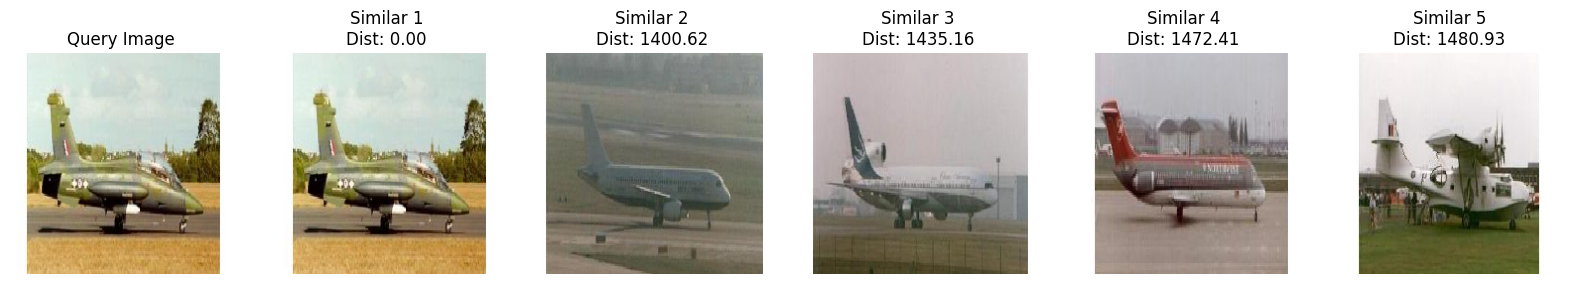

In [25]:
print(f"Top 5 imágenes similares a {query_image_path}:")
for img_path, dist in similar_images:
    print(f"{img_path} con una distancia de {dist:.2f}")

show_images(query_image_path, similar_images)